### Imports et initialisations

In [5]:
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras as keras
import random
import re
from nltk.corpus import stopwords
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
from clustertools import *

In [30]:
#répertoire dans lequel seront stockés les clusters, doit se terminer obligatoirement par /
cluster_dir = "clusters/d2v_1M_Min/"
clean_dataset_file = "datasets/MillionTweetsMin_NEFU.txt"
raw_dataset_file = "datasets/MillionTweets_NEFU.txt"

##### Récupération des tweets

In [8]:
with open(clean_dataset_file, "r") as file:
    lines = file.readlines()
    
clean_sample = [line.split() for line in lines]

with open(raw_dataset_file, "r") as file:
    raw_sample = file.readlines()

### Encodage à l'aide d'un modèle doc2vec entraîné avec les données

On charge le modèle depuis le disque

In [9]:
from gensim.models import Doc2Vec

In [12]:
d2v = Doc2Vec.load("models/doc2v_model_global_Min")

In [13]:
%%time
#encodage de l'échantillon pour créer le jeu de données
dataset_encoded = np.array([d2v.infer_vector(tweet) for tweet in clean_sample])

CPU times: user 7min 55s, sys: 1.54 s, total: 7min 56s
Wall time: 7min 57s


### Visualisation du dataset

- On réalise une réduction de dimension afin de visualiser les données dans une grille en deux dimensions
- On utilise pour cela la méthode PCA

In [14]:
%%time

pca = PCA(n_components=2)

#On crée une version en deux dimensions de notre jeu de données
two_dim_dataset = pca.fit_transform(dataset_encoded)

CPU times: user 25.3 s, sys: 16.3 s, total: 41.6 s
Wall time: 18.3 s


In [15]:
#On utilise la matrice transposée de notre jeu de données pour pouvoir visualiser les données
b = two_dim_dataset.T

#Taille des figures
plt.rcParams["figure.figsize"] = (10,10)

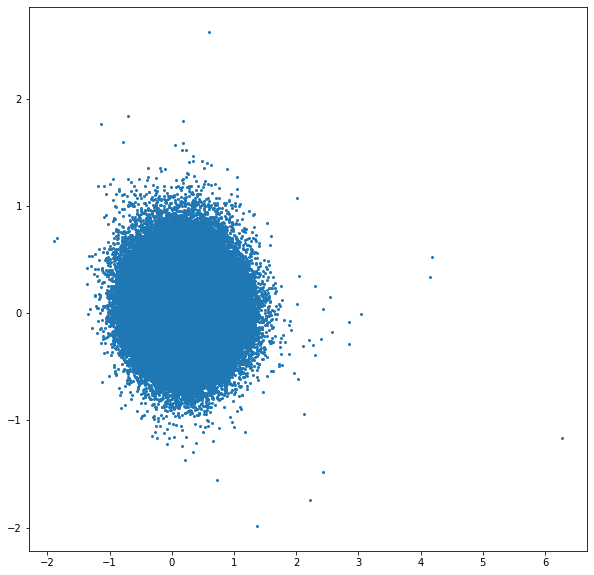

In [19]:
#Affichage des données
plt.scatter(b[0], b[1], marker='.')
plt.show()

In [26]:
#transfert des globales au module clustertools
init_globals(clean_sample, raw_sample, two_dim_dataset, cluster_dir)

### Kmeans

In [20]:
n_clust = 10

In [21]:
%%time
km_model = KMeans(n_clusters=n_clust, random_state=0)
kmeans = km_model.fit(dataset_encoded)

CPU times: user 14min 56s, sys: 3min 29s, total: 18min 25s
Wall time: 2min 27s


In [22]:
km_pred = kmeans.predict(dataset_encoded)

Cluster 0 : 130446 messages
1065 messages contiennent un mot-clé haineux (soit 0.82%)
Les 20 mots les plus fréquents : fait faire sont va comme même bien ils quand j’ai suis y mon trop elle cette j'ai ma être ont 


Cluster 1 : 9870 messages
104 messages contiennent un mot-clé haineux (soit 1.05%)
Les 20 mots les plus fréquents : ou sont comme fait faire même quand ils y bien nous être elle son va / moi cette ont suis 


Cluster 2 : 18332 messages
196 messages contiennent un mot-clé haineux (soit 1.07%)
Les 20 mots les plus fréquents : son mon leur ton votre notre sa fait cette même faire ma comme elle quand j'ai sont bien suis nous 


Cluster 3 : 54713 messages
594 messages contiennent un mot-clé haineux (soit 1.09%)
Les 20 mots les plus fréquents : sont nous ils fait comme faire son y ont aux même cette sa quand bien être va leur elle tous 


Cluster 4 : 19470 messages
148 messages contiennent un mot-clé haineux (soit 0.76%)
Les 20 mots les plus fréquents : .. .... sont fait comme mê

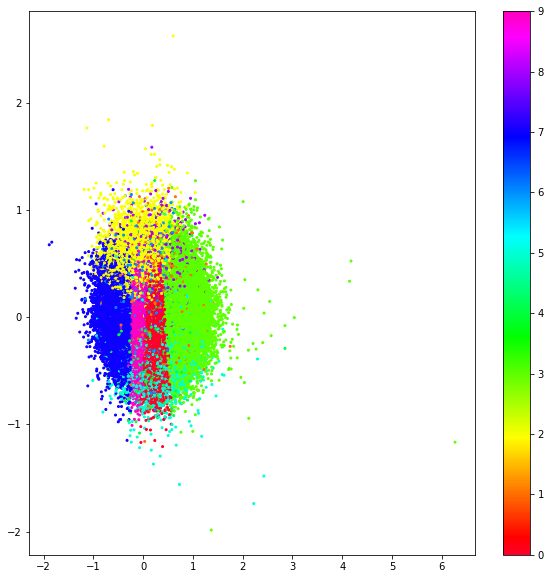

In [28]:
parse_no_save(km_pred)

Cluster 0 : 130446 messages
1065 messages contiennent un mot-clé haineux (soit 0.82%)
Les 20 mots les plus fréquents : fait faire sont va comme même bien ils quand j’ai suis y mon trop elle cette j'ai ma être ont 


Cluster 1 : 9870 messages
104 messages contiennent un mot-clé haineux (soit 1.05%)
Les 20 mots les plus fréquents : ou sont comme fait faire même quand ils y bien nous être elle son va / moi cette ont suis 


Cluster 2 : 18332 messages
196 messages contiennent un mot-clé haineux (soit 1.07%)
Les 20 mots les plus fréquents : son mon leur ton votre notre sa fait cette même faire ma comme elle quand j'ai sont bien suis nous 


Cluster 3 : 54713 messages
594 messages contiennent un mot-clé haineux (soit 1.09%)
Les 20 mots les plus fréquents : sont nous ils fait comme faire son y ont aux même cette sa quand bien être va leur elle tous 


Cluster 4 : 19470 messages
148 messages contiennent un mot-clé haineux (soit 0.76%)
Les 20 mots les plus fréquents : .. .... sont fait comme mê

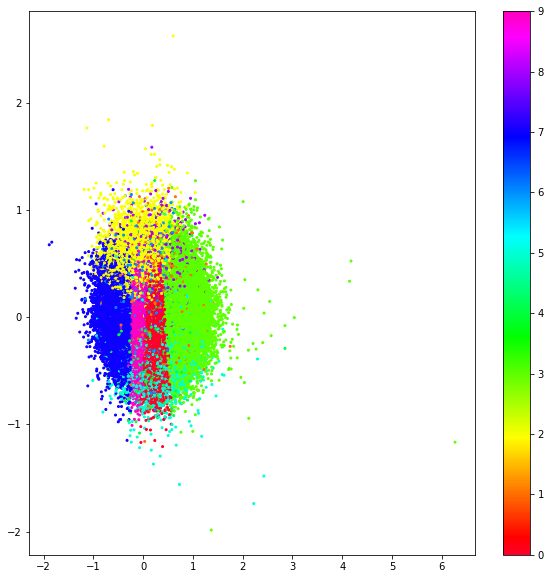

In [29]:
parse_results(km_pred, 'km_10')

### SOM

In [31]:
from minisom import MiniSom

In [32]:
m = 10
n = 10
som = MiniSom(m, n, 300, neighborhood_function='gaussian', random_seed=0)
som.pca_weights_init(dataset_encoded)

In [33]:
%%time
som.train(dataset_encoded, 100000, verbose=True)

 [ 100000 / 100000 ] 100% - 0:00:00 left 
 quantization error: 0.7628292290415944
CPU times: user 41.5 s, sys: 10.4 s, total: 51.9 s
Wall time: 50.3 s


In [34]:
%%time
pred = []
for msg in dataset_encoded:
    winner = som.winner(msg)
    pred.append(winner[0]*n+winner[1])

CPU times: user 47.8 s, sys: 29.3 ms, total: 47.8 s
Wall time: 47.9 s


Cluster 0 : 2123 messages
23 messages contiennent un mot-clé haineux (soit 1.08%)
Les 20 mots les plus fréquents : nous notre nos ils sont faire comme fait cette même son ont aux ou bien ces y tous ) leur 


Cluster 1 : 947 messages
11 messages contiennent un mot-clé haineux (soit 1.16%)
Les 20 mots les plus fréquents : te ton lui fait mon moi toi quand même faire juste bien ta elle jamais ma suis rien comme j’ai 


Cluster 2 : 1659 messages
17 messages contiennent un mot-clé haineux (soit 1.02%)
Les 20 mots les plus fréquents : toujours même sont fait son quand y comme ils ou bien mon jamais faire nous leur ont aux cette elle 


Cluster 3 : 1635 messages
15 messages contiennent un mot-clé haineux (soit 0.92%)
Les 20 mots les plus fréquents : bien même sont comme quand y ils fait son qu'il faire être suis aussi ont nous trop va juste ou 


Cluster 4 : 4764 messages
36 messages contiennent un mot-clé haineux (soit 0.76%)
Les 20 mots les plus fréquents : bien trop fait sont faire comme s

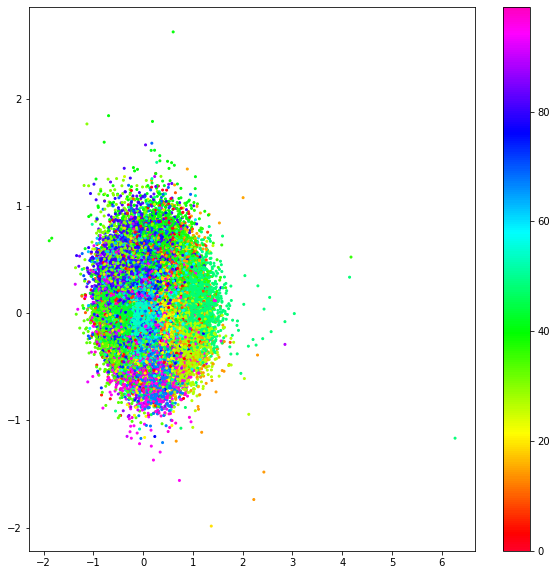

In [36]:
parse_no_save(pred)